In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import time
from pytz import timezone
import pandas as pd

Посмотрим, за какой период предоставлены данные:

In [2]:
def get_datetime(timestamp):
    return datetime.fromtimestamp(int(timestamp), timezone('Europe/Moscow'))

df = pd.read_csv('alert_button.csv', names=['device_id', 'timestamp', 'x', 'y'])
print('Start:', get_datetime(df.timestamp.min()).strftime('%c'))
print('End:  ', get_datetime(df.timestamp.max()).strftime('%c'))


Start: Mon Jan 25 03:00:17 2016
End:   Mon Feb  1 02:59:43 2016


Видно, что мы имеем сигналы за неделю. Посмотрим на распределение по дням: 

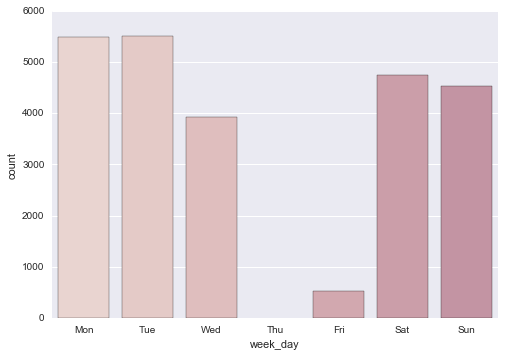

In [3]:
df['week_day'] = df.timestamp.map(lambda x: get_datetime(x).strftime('%a'))
week_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
img = sns.countplot(x = 'week_day', data = df, order=week_days, palette=sns.cubehelix_palette(20))

Странно, но в середине недели есть пропуски - видно, что данные неоднородны. Посмотрим на распределение по времени прихода сигналов:

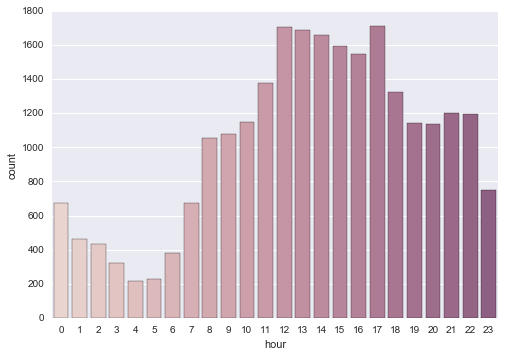

In [4]:
df['hour'] = df.timestamp.map(lambda x: get_datetime(x).time().hour)
img = sns.countplot(x = 'hour', data = df, palette=sns.cubehelix_palette(40))

Очень хорошо видна корелляция между временем суток и активностью поступающих сигналов - ночью спад, в дневное время ярко выраженный подъем. 

Отсюда главная идея - люди спят, и чтобы найти координаты места жительства, нужно найти место, откуда поступает больше сигналов в ночное время. И будем надеяться, что среди носителей тревожных браслетов нет таксистов или любителей зажигать по ночам.

Построим распределение сигналов по координатам с некотрых браслетов днем и ночью. Я просмотрел все, но для наглядности покажем лишь некоторые из них:

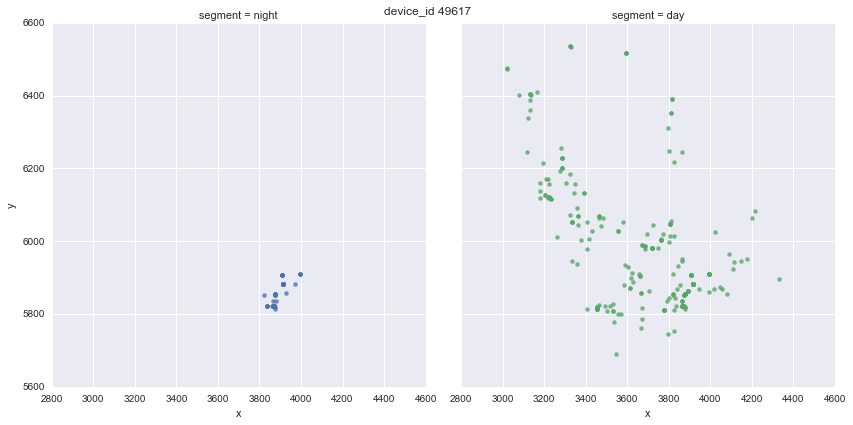

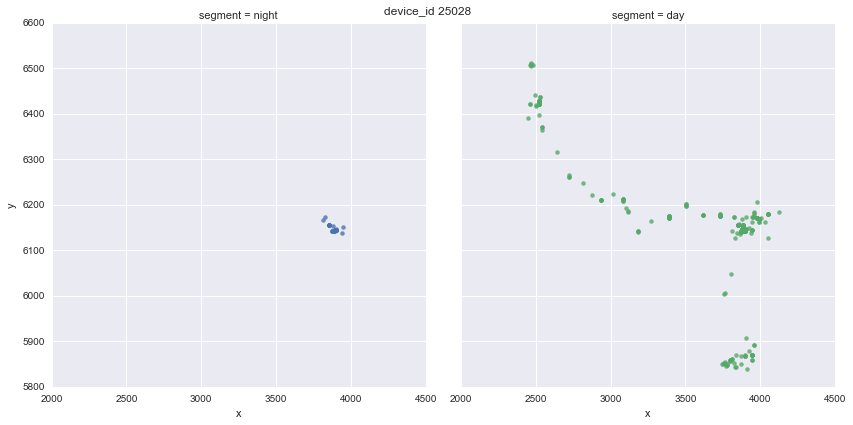

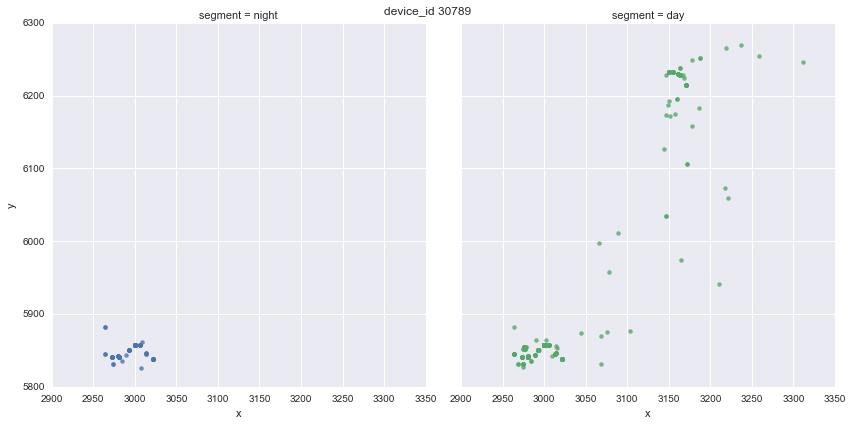

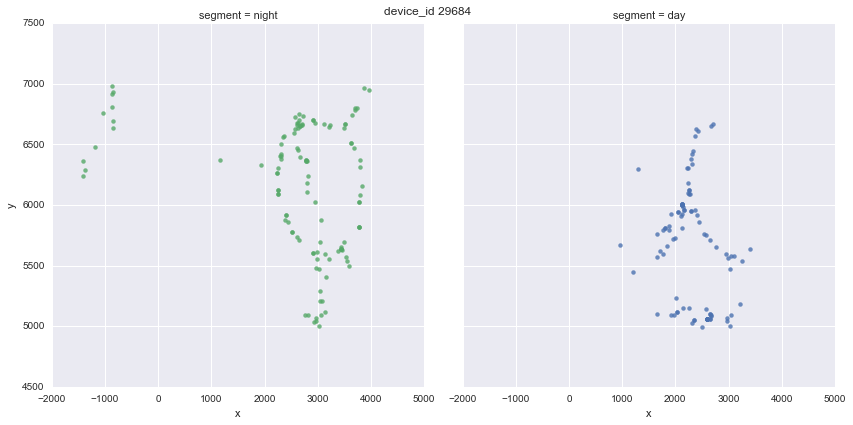

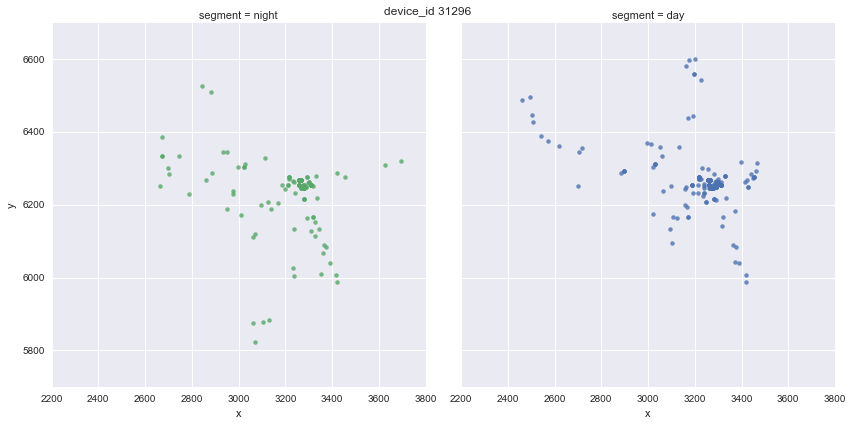

In [5]:
def part_of_day(hour):
    if hour < 6 or hour == 23: return 'night'
    else: return 'day'
    
df['segment'] = df.hour.map(part_of_day) 

devices = [49617, 25028, 30789, 29684, 31296]

for i in devices:
    df1 = df[df.device_id == i]
    img = sns.lmplot(x='x', y = 'y', data=df1, hue='segment', col='segment', col_order= ['night', 'day'], fit_reg=False, size=6)
    img.fig.suptitle('device_id ' + str(i))

Все-таки таксисты присутствуют в датасете. Но, к счастью, их не так много.

Еще одно наблюдение - почти все точечные скопления сигналов попадают в квадрат со стороной 100-80, поэтому имеет смысл взять 100 как ширину сетки.

Итак, алгоритм:
* берем координатную сетку с расстоянием 100
* по каждому пользователю в каждой ячейке считаем количество дневных и ночных сигналов и "средние координаты" от всех сигналов внутри
* выбираем ячейку с максимальным количеством ночных сигналов, но если их слишком мало (меньше пяти), считаем ночные данные неточными и выбираем ячейку с максимумом сигналов за все время
* из полученной ячейки берем среднее значение координат - это и будут координаты дома

Некоторые детали:
* всесто *groupByKey()* в спарке используем *combineByKey()*, чтобы уменьшить трафик при shuffle и не нарваться на OutOfMemory в случае большого датасета
* сложность алгоритма линейно зависит от количества записей, если не учитывать сложность операции shuffle. В самом алгоритме нет ни сортировок, ни хранения данных в упорядоченных структурах вроде деревьев

Возможные оптимизации:
* более точно настроить ширину сетки, зная реальный масштаб координат и погрешность данных с браслетов
* подумать над аудиторией носителей браслетов - возможно стоит исключить некоторые ночи из наблюдений, например ночь пятницы и субботы, или сдвинуть ночной интервал в эти дни на несколько часов вперед
* использовать одновременно две сетки, наложенные друг на друга и сдвинутые на половину ширины ячейки (50) по обоим координатам - это поможет в случае, когда скопление сигналов приходится на пересечение линий одной из сеток. Для ответа выбираем ячейку с максимумом сигналов по обоим сеткам
* ввести понятие "скорости" - расстояния между точками координат, поделенное на прошедшее время. Если скорость большая - человек двигался, если маленькая - находился в одном месте. Идея интересная, но я решил на ней не фокусироваться из-за того, что данные приходят хаотично, а не через равные интервалы 
